In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

class SinDataset(Dataset):
    def __init__(self, x, included_timesteps, shift):
        """
        Initialize the dataset with the data.

        Args:
            data (list or array-like): List of numbers to use as data.
        """
        self.data = x
        self.included_timesteps = included_timesteps
        self.shift = shift

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.data)-self.included_timesteps

    def __getitem__(self, idx):
        """
        Fetch the data and its label at index `idx`.

        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            tuple: (data, label) where label is the square of the data.
        """
        x = np.sin(self.data[idx:idx+self.included_timesteps] + self.shift)  # Get the input data
        y = np.sin(self.data[idx+self.included_timesteps] + self.shift)         # Label is the square of the input
        return x, y


## Loading data

In [86]:

included_timesteps = 200
timeline = np.linspace(0, 120, 1000)
x1 = SinDataset(timeline, included_timesteps, 0)
x2 = SinDataset(timeline, included_timesteps, 1)
dataloader1 = DataLoader(x1, batch_size=1)
dataloader2 = DataLoader(x2, batch_size=1)

In [73]:
for (x1, y1), (x2, y2) in zip(dataloader1, dataloader2):
    print(x1.shape, y1.shape, x1.shape, y1.shape)
    x = torch.stack((x1, x2), dim=2).float()
    y = torch.stack((y1, y2), dim=1).float()
    print(x.shape, y.shape)
    print(x.dtype, y)
    break

torch.Size([1, 50]) torch.Size([1]) torch.Size([1, 50]) torch.Size([1])
torch.Size([1, 50, 2]) torch.Size([1, 2])
torch.float32 tensor([[-0.2679,  0.6660]])


## Setting up Network

In [74]:
class Net(nn.Module):
    def __init__(self, n_neurons, input_shape):
        super(Net, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=input_shape, hidden_size=n_neurons, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=input_shape, hidden_size=n_neurons, batch_first=True)

        self.fc1 = nn.Linear(n_neurons, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc = nn.Linear(2*n_neurons, 2)
    
    def forward(self, x):
        _, (h_n1, _) = self.lstm1(x[:, :, 0])
        _, (h_n2, _) = self.lstm2(x[:, :, 1])
        out = torch.cat((h_n1, h_n2))
        out = torch.flatten(out)
        out = self.fc(out)
        return out

# Training loop

In [96]:
n_neurons = 12
epochs = 10

model = Net(n_neurons, included_timesteps)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_curve = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

for epoch in range(epochs):
    loss_total = 0
    model.train()

    for (x1, y1), (x2, y2) in zip(dataloader1, dataloader2):
        optimizer.zero_grad()
        x = torch.stack((x1, x2), dim=2).float().to(device)
        y = torch.flatten(torch.stack((y1, y2), dim=1).float()).to(device)

        predictions = model(x)
        loss = loss_function(predictions, y)
        loss_total += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch}: {loss_total=}')


Epoch 0: loss_total=39.42034426373948
Epoch 1: loss_total=2.862041364015795
Epoch 2: loss_total=2.0416068957115456
Epoch 3: loss_total=4.122144442737863
Epoch 4: loss_total=0.45919761658162983
Epoch 5: loss_total=4.053918495054859
Epoch 6: loss_total=0.907058867929095
Epoch 7: loss_total=2.7429374811590606
Epoch 8: loss_total=1.6598466815394204
Epoch 9: loss_total=1.6496848913284339


## Predictions

In [97]:
# Predicting stuff
for (x1, y1), (x2, y2) in zip(dataloader1, dataloader2):
    x = torch.stack((x1, x2), dim=2).float()
    y = torch.flatten(torch.stack((y1, y2), dim=1).float())
    break

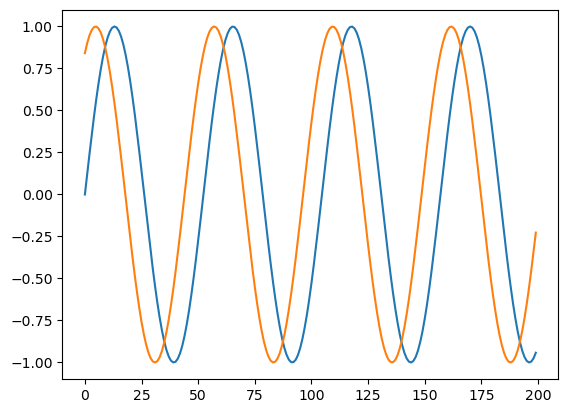

In [98]:
plt.plot(x[0])

In [99]:
prediction = []
for n in range(200):
  pred = model(x)
  y = torch.clone(x[:, 1:, :])
  new_x = pred.reshape((1, 1, 2))
  x = torch.cat((y, new_x), axis=1)
  prediction.append(new_x[0, 0, :].detach().numpy())

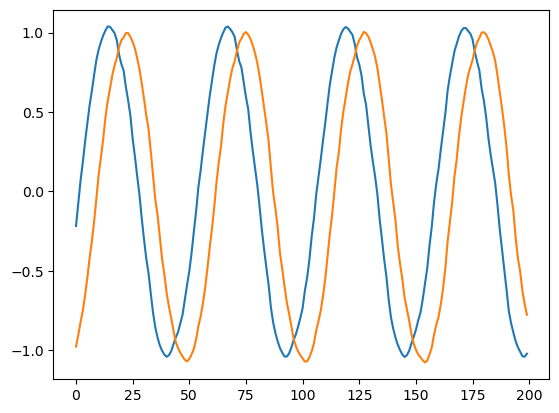

In [100]:
plt.plot(np.array(prediction).T[1])
plt.plot(np.array(prediction).T[0])